In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("data/raw/urban_civic_reports_synthetic.csv")
print(f"Loaded {len(df)} complaints")
print(df.head())

Loaded 1600 complaints
   ID     Category     Status   Latitude  Longitude
0   1     Drainage    Pending  23.257167  77.413640
1   2        Waste  Completed  23.258523  77.415287
2   3      Pothole  Completed  23.256676  77.411646
3   4        Waste  Completed  23.261520  77.407977
4   5  Streetlight    Pending  23.257405  77.412233


In [4]:
print("\n" + "="*70)
print("FEATURE 1: DUPLICATE COMPLAINT DETECTION")
print("="*70)

sample_descriptions = [
    "Pothole on main road near school",
    "Big hole in road near school",
    "Garbage piled up near market",
    "Trash accumulated in market area",
    "Streetlight broken at junction",
    "Streetlight not working near junction",
    "Water leakage from pipeline",
    "Sewer overflow near hospital"
]

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 2))
tfidf_matrix = vectorizer.fit_transform(sample_descriptions)
cosine_sim = cosine_similarity(tfidf_matrix)

print("\nText Similarity Matrix (Cosine Similarity):")
sim_df = pd.DataFrame(
    cosine_sim,
    columns=[f"Complaint {i}" for i in range(len(sample_descriptions))],
    index=[f"Complaint {i}" for i in range(len(sample_descriptions))]
)
print(sim_df.round(3))


FEATURE 1: DUPLICATE COMPLAINT DETECTION

Text Similarity Matrix (Cosine Similarity):
             Complaint 0  Complaint 1  Complaint 2  Complaint 3  Complaint 4  \
Complaint 0        1.000        0.737        0.213        0.151        0.085   
Complaint 1        0.737        1.000        0.173        0.128        0.072   
Complaint 2        0.213        0.173        1.000        0.267        0.050   
Complaint 3        0.151        0.128        0.267        1.000        0.250   
Complaint 4        0.085        0.072        0.050        0.250        1.000   
Complaint 5        0.140        0.154        0.147        0.172        0.617   
Complaint 6        0.114        0.126        0.232        0.085        0.076   
Complaint 7        0.152        0.167        0.129        0.031        0.000   

             Complaint 5  Complaint 6  Complaint 7  
Complaint 0        0.140        0.114        0.152  
Complaint 1        0.154        0.126        0.167  
Complaint 2        0.147        0

In [5]:
print("\nSimilar Complaint Pairs (Similarity > 0.7):")
threshold = 0.7
similar_pairs = []
for i in range(len(cosine_sim)):
    for j in range(i + 1, len(cosine_sim)):
        if cosine_sim[i, j] > threshold:
            similar_pairs.append((i, j, cosine_sim[i, j]))
            print(f"Complaint {i} <-> Complaint {j}: {cosine_sim[i, j]:.3f}")
            print(f"  → '{sample_descriptions[i]}'")
            print(f"  → '{sample_descriptions[j]}'")


Similar Complaint Pairs (Similarity > 0.7):
Complaint 0 <-> Complaint 1: 0.737
  → 'Pothole on main road near school'
  → 'Big hole in road near school'


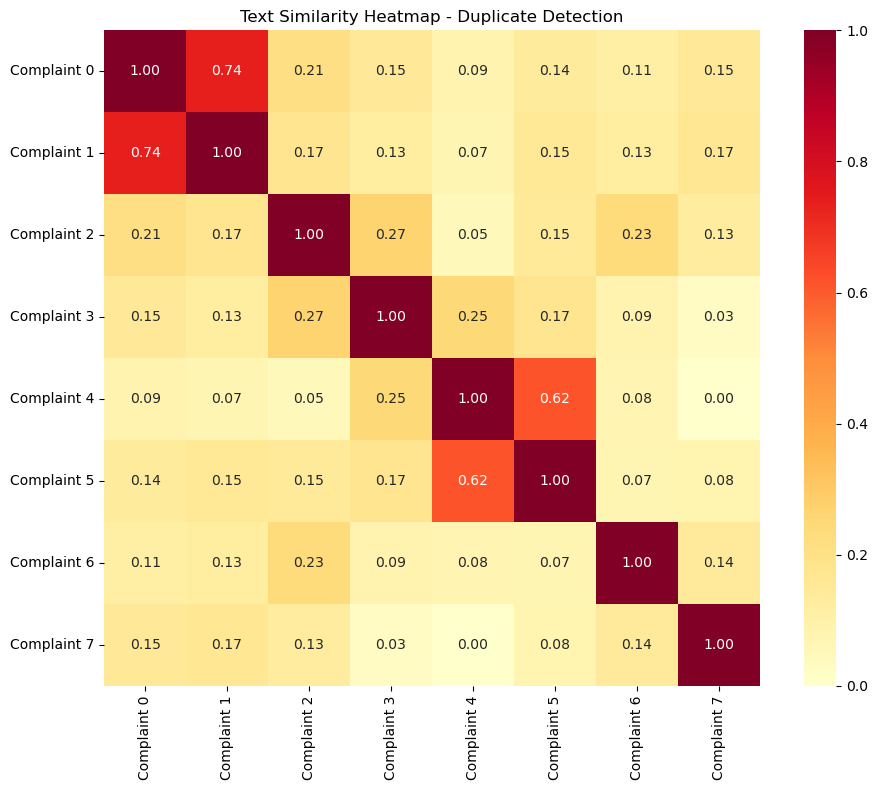

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, cmap='YlOrRd', fmt='.2f', square=True)
plt.title('Text Similarity Heatmap - Duplicate Detection')
plt.tight_layout()
plt.show()


FEATURE 2: GEOSPATIAL HOTSPOT CLUSTERING

Top 5 Hotspots:
    lat_grid  lon_grid  complaint_count
17     23.25     77.41              205
24     23.26     77.41              163
16     23.25     77.40              106
32     23.27     77.42              101
33     23.27     77.43               96


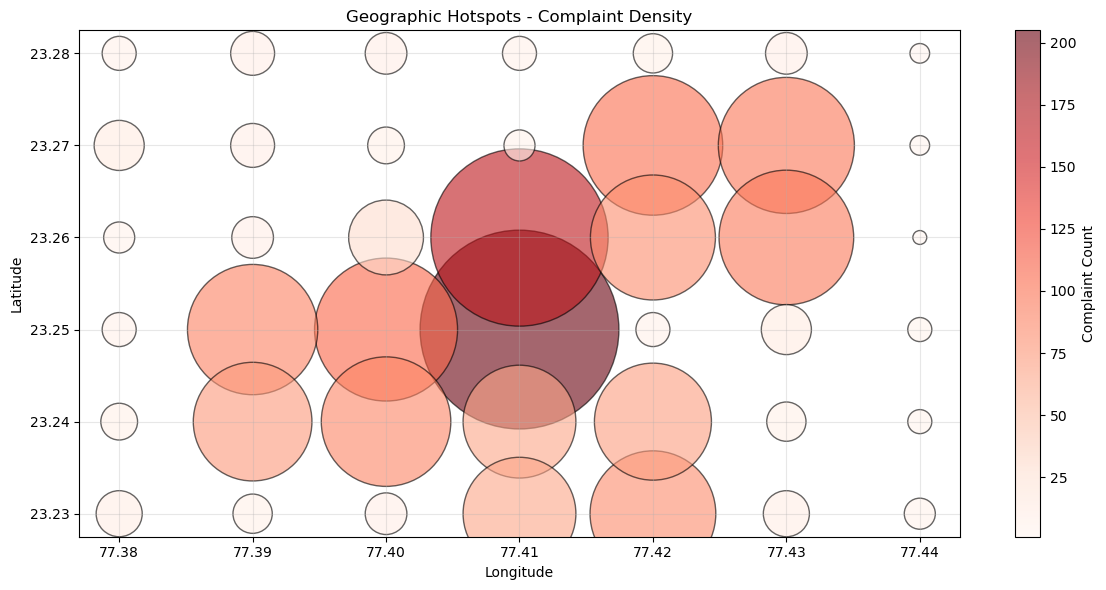

In [7]:
print("\n" + "="*70)
print("FEATURE 2: GEOSPATIAL HOTSPOT CLUSTERING")
print("="*70)

lat_col = "Latitude"
lon_col = "Longitude"

grid_size = 0.01
df['lat_grid'] = (df['Latitude'] // grid_size * grid_size).round(3)
df['lon_grid'] = (df['Longitude'] // grid_size * grid_size).round(3)

cell_counts = (
    df.groupby(['lat_grid', 'lon_grid'])
      .size()
      .reset_index(name='complaint_count')
)

df = df.merge(
    cell_counts,
    on=['lat_grid', 'lon_grid'],
    how='left'
)

df['location_density'] = df['complaint_count']

hotspots = df.groupby(['lat_grid', 'lon_grid']).size().reset_index(name='complaint_count')
hotspots = hotspots.sort_values('complaint_count', ascending=False)

print("\nTop 5 Hotspots:")
print(hotspots.head())

plt.figure(figsize=(12, 6))
plt.scatter(hotspots['lon_grid'], hotspots['lat_grid'], 
           s=hotspots['complaint_count']*100, alpha=0.6, c=hotspots['complaint_count'],
           cmap='Reds', edgecolors='black')
plt.colorbar(label='Complaint Count')
plt.title('Geographic Hotspots - Complaint Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
print("\n" + "="*70)
print("FEATURE 3: LEARNED PRIORITY SCORING")
print("="*70)

np.random.seed(42)
df['days_to_resolve'] = np.random.randint(1, 30, len(df))


df['priority_label'] = pd.cut(df['days_to_resolve'], 
                               bins=[0, 1, 3, 7, 30], 
                               labels=['CRITICAL', 'HIGH', 'MEDIUM', 'LOW'])

print("\nPriority Distribution:")
print(df['priority_label'].value_counts())


FEATURE 3: LEARNED PRIORITY SCORING

Priority Distribution:
priority_label
LOW         1195
MEDIUM       217
HIGH         114
CRITICAL      74
Name: count, dtype: int64


In [9]:
df['location_density'] = df.groupby(['lat_grid', 'lon_grid'])['complaint_count'].transform('count')
df['hour_of_day'] = np.random.randint(0, 24, len(df))

from sklearn.ensemble import RandomForestClassifier

features_for_priority = df[['location_density', 'hour_of_day']].fillna(0)
X_priority = StandardScaler().fit_transform(features_for_priority)
y_priority = df['priority_label'].map({'CRITICAL': 3, 'HIGH': 2, 'MEDIUM': 1, 'LOW': 0})

rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_priority, y_priority)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",10
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [10]:
print("\nPriority Model Feature Importance:")
for feat, imp in zip(['location_density', 'hour_of_day'], rf_model.feature_importances_):
    print(f"  {feat}: {imp:.3f}")

new_complaint = np.array([[5, 14]])
new_complaint_scaled = StandardScaler().fit_transform(features_for_priority).mean(axis=0, keepdims=True)
priority_pred = rf_model.predict(new_complaint_scaled.reshape(1, -1))[0]
priority_map = {3: 'CRITICAL', 2: 'HIGH', 1: 'MEDIUM', 0: 'LOW'}
print(f"\nSample prediction: Priority = {priority_map[priority_pred]}")


Priority Model Feature Importance:
  location_density: 0.620
  hour_of_day: 0.380

Sample prediction: Priority = LOW



FEATURE 4: TEMPORAL ANALYSIS & TRENDS

Daily Complaint Counts:
date
2030-03-10    1
2030-03-11    1
2030-03-12    1
2030-03-13    1
2030-03-14    1
2030-03-15    1
2030-03-16    1
2030-03-17    1
2030-03-18    1
2030-03-19    1
dtype: int64


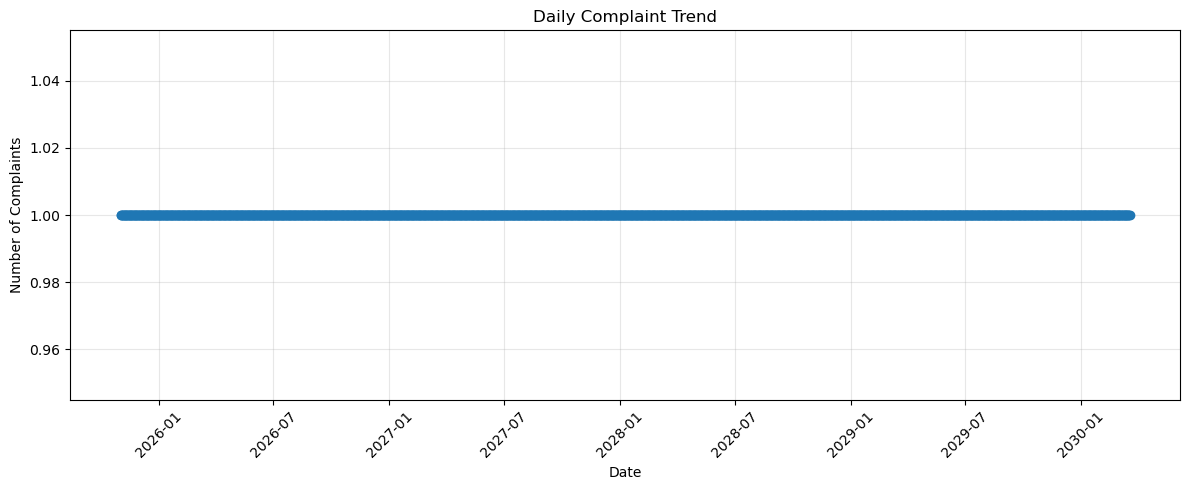

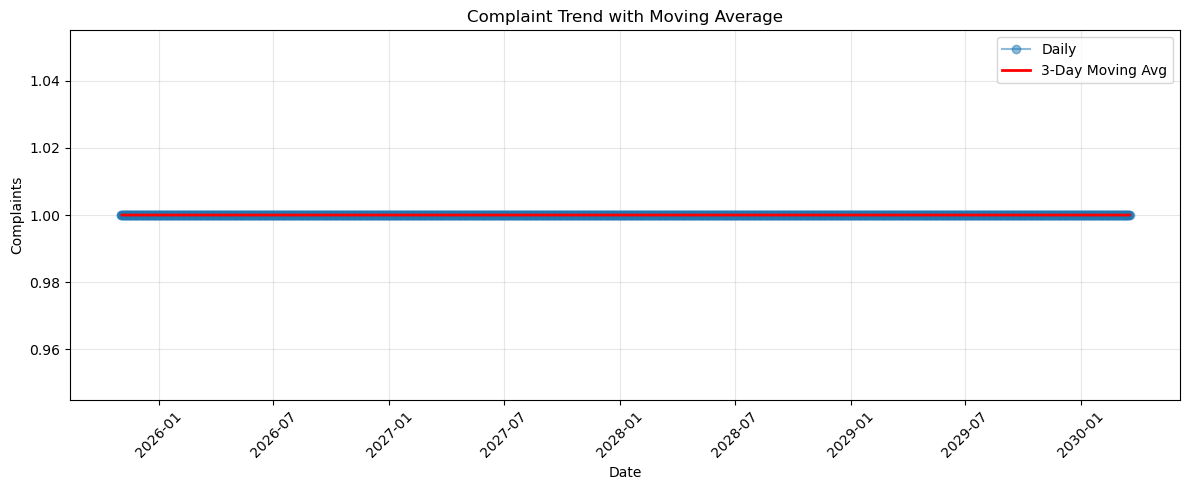

In [11]:
print("\n" + "="*70)
print("FEATURE 4: TEMPORAL ANALYSIS & TRENDS")
print("="*70)


df['date'] = pd.date_range(start='2025-11-01', periods=len(df), freq='D')
daily_complaints = df.groupby(df['date'].dt.date).size()

print("\nDaily Complaint Counts:")
print(daily_complaints.tail(10))


plt.figure(figsize=(12, 5))
plt.plot(daily_complaints.index, daily_complaints.values, marker='o', linestyle='-', linewidth=2)
plt.title('Daily Complaint Trend')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


moving_avg = daily_complaints.rolling(window=3).mean()
plt.figure(figsize=(12, 5))
plt.plot(daily_complaints.index, daily_complaints.values, label='Daily', marker='o', alpha=0.5)
plt.plot(moving_avg.index, moving_avg.values, label='3-Day Moving Avg', linewidth=2, color='red')
plt.title('Complaint Trend with Moving Average')
plt.xlabel('Date')
plt.ylabel('Complaints')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
print("\n" + "="*70)
print("FEATURE 5: RECURRING ISSUE DETECTION")
print("="*70)
recurring = df.groupby(['lat_grid', 'lon_grid', 'Category']).size().reset_index(name='count')
recurring = recurring[recurring['count'] > 1].sort_values('count', ascending=False)

print("\nTop Recurring Issues (Same location, same category):")
print(recurring.head(10))

if len(recurring) > 0:
    print("\nPREVENTIVE MAINTENANCE RECOMMENDATIONS:")
    for idx, row in recurring.head(3).iterrows():
        print(f"  • {row['Category']} at ({row['lat_grid']:.4f}, {row['lon_grid']:.4f}): "
              f"{row['count']} reports - SCHEDULE MAINTENANCE")



FEATURE 5: RECURRING ISSUE DETECTION

Top Recurring Issues (Same location, same category):
     lat_grid  lon_grid     Category  count
79      23.25     77.41        Waste     65
77      23.25     77.41      Pothole     61
106     23.26     77.41        Waste     51
104     23.26     77.41      Pothole     42
74      23.25     77.40        Waste     35
105     23.26     77.41  Streetlight     34
111     23.26     77.42        Waste     33
22      23.23     77.42        Waste     31
72      23.25     77.40      Pothole     31
76      23.25     77.41     Drainage     31

PREVENTIVE MAINTENANCE RECOMMENDATIONS:
  • Waste at (23.2500, 77.4100): 65 reports - SCHEDULE MAINTENANCE
  • Pothole at (23.2500, 77.4100): 61 reports - SCHEDULE MAINTENANCE
  • Waste at (23.2600, 77.4100): 51 reports - SCHEDULE MAINTENANCE


In [13]:
print("\n" + "="*70)
print("ML INSIGHTS SUMMARY")
print("="*70)

summary_stats = {
    'Total Complaints': len(df),
    'Unique Locations': len(df.groupby(['lat_grid', 'lon_grid'])),
    'Duplicate Pairs Detected': len(similar_pairs),
    'Recurring Issues': len(recurring[recurring['count'] > 1]),
    'High-Density Zones': len(hotspots[hotspots['complaint_count'] >= 2]),
    'Avg Days to Resolve': df['days_to_resolve'].mean(),
    'Priority Dist - HIGH': (df['priority_label'] == 'HIGH').sum(),
}

print("\nKEY METRICS:")
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")

results_export = pd.DataFrame({
    'Analysis': list(summary_stats.keys()),
    'Value': list(summary_stats.values())
})
results_export.to_csv('analysis_results.csv', index=False)
print("\nResults saved to 'analysis_results.csv'")


ML INSIGHTS SUMMARY

KEY METRICS:
  Total Complaints: 1600
  Unique Locations: 42
  Duplicate Pairs Detected: 1
  Recurring Issues: 127
  High-Density Zones: 41
  Avg Days to Resolve: 15.10
  Priority Dist - HIGH: 114

Results saved to 'analysis_results.csv'
